Notebook used to contain some more 'experimental' code to examine confusion matrix creation with a SGD classifier on the MNIST dataset

First... Get the data

In [1]:
from sklearn.datasets import fetch_openml
import time

In [2]:
tic = time.perf_counter ()
mnist = fetch_openml ('mnist_784', version=1)
toc = time.perf_counter ()
loadTime = toc - tic
print (f'Time to preform Fetch: {loadTime:0.4f} seconds')

Time to preform Fetch: 33.0667 seconds


Make a test and train set.

In [5]:
import numpy as np
X = mnist ['data']
y = mnist ['target']
y = y.astype (np.uint8)

In [6]:
TRAIN_TEST_SPLIT = 10000
X_train, X_test = X[:(X.shape[0] - TRAIN_TEST_SPLIT)], X[(X.shape[0] - TRAIN_TEST_SPLIT):]
y_train, y_test = y[:(X.shape[0] - TRAIN_TEST_SPLIT)], y[(X.shape[0] - TRAIN_TEST_SPLIT):]

In [ ]:
Make a classifier and train it...

In [3]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier (random_state=42)

In [7]:
tic = time.perf_counter()
clf.fit (X_train, y_train)
toc = time.perf_counter()
trainTime = toc - tic
print (f'Time to preform fit data: {trainTime:0.4f} seconds')

Time to preform fit data: 153.9496 seconds


Determine the confusion matrix...

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict (clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix (y_train, y_train_pred)

In [11]:
conf_mx

array([[5547,    1,   71,   30,    7,   57,   61,   10,   92,   47],
       [   3, 6297,  198,   32,   10,   25,   16,   25,  107,   29],
       [  28,   41, 5315,  122,   47,   28,  104,  101,  142,   30],
       [   9,   19,  286, 5094,   15,  290,   35,   82,  125,  176],
       [   6,   21,   71,   35, 5241,   15,   49,   54,   66,  284],
       [  45,   15,   78,  400,   88, 4212,  141,   34,  272,  136],
       [  21,   10,   80,    9,   37,   92, 5593,    2,   64,   10],
       [  18,   18,   71,   29,   73,   11,    5, 5821,   18,  201],
       [  29,  114,  179,  273,   59,  254,   59,   61, 4573,  250],
       [  15,   14,   49,  137,  194,   45,    1,  552,   75, 4867]])

Create a heatmap of the confusion matrix...

Text(499.55999999999995, 0.5, 'Actual Values')

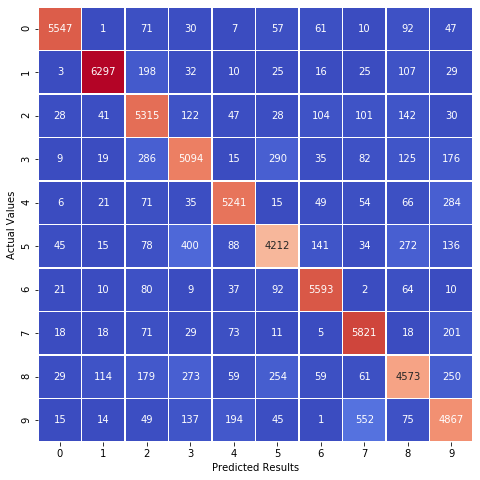

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (20,8))
sns.heatmap (conf_mx, annot=True, fmt="d", linewidths=.5, cmap="coolwarm", cbar=False, square=True)
plt.xlabel ('Predicted Results')
plt.ylabel ('Actual/Expected Values')

Next, the plot on the errors.... divide each value in the confusion matrix by the number of images in the corresponding class.  Also zero out the diagonal to avoid any confusion.

Text(616.9200000000001, 0.5, 'Actual/Expected Values')

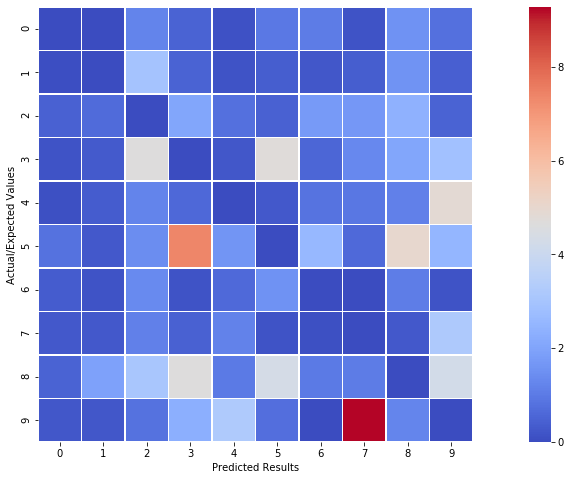

In [113]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums * 100
np.fill_diagonal(norm_conf_mx, 0)
plt.figure(figsize = (20,8))
sns.heatmap (norm_conf_mx, linewidths=.5, cmap="coolwarm", square=True)
plt.xlabel ('Predicted Results')
plt.ylabel ('Actual/Expected Values')

Get the indices for each number...

In [35]:
# go through everything and determine the indices of all numbers in the train set... perhaps this is too much
indices = [ [], [], [], [], [], [], [], [], [], [] ]
for i in range(len(y_train)):
    if y_train[i] == 0:
        indices[0].append (i)
    elif y_train[i] == 1:
        indices[1].append (i)
    elif y_train[i] == 2:
        indices[2].append (i)
    elif y_train[i] == 3:
        indices[3].append (i)
    elif y_train[i] == 4:
        indices[4].append (i)
    elif y_train[i] == 5:
        indices[5].append (i)
    elif y_train[i] == 6:
        indices[6].append (i)
    elif y_train[i] == 7:
        indices[7].append (i)
    elif y_train[i] == 8:
        indices[8].append (i)
    elif y_train[i] == 9:
        indices[9].append (i)
        

for i in range (5):
    print (indices[0][i], indices[1][i], indices[2][i], indices[3][i], indices[4][i], indices[5][i])
    
for i in indices:
    print (len(i))

1 3 5 7 2 0
21 6 16 10 9 11
34 8 25 12 20 35
37 14 28 27 26 47
51 23 76 30 53 65
5923
6742
5958
6131
5842
5421
5918
6265
5851
5949


From the confusion matrix, pre-allocate a few 'cases of interest'

In [96]:
# 3 - 2,  3 - 5,  4 - 9,  5 - 3,  5 - 8,  8 - 3,  8 - 5,  8 - 9,  9 - 7 
casesOfInterest = [
    { 'expectedValue': 3, 'predictedValue': 2, 'goodIndices': [], 'badIndices': [] },
    { 'expectedValue': 3, 'predictedValue': 5, 'goodIndices': [], 'badIndices': [] },
    { 'expectedValue': 4, 'predictedValue': 9, 'goodIndices': [], 'badIndices': [] },
    { 'expectedValue': 5, 'predictedValue': 3, 'goodIndices': [], 'badIndices': [] },
    { 'expectedValue': 5, 'predictedValue': 8, 'goodIndices': [], 'badIndices': [] },
    { 'expectedValue': 8, 'predictedValue': 3, 'goodIndices': [], 'badIndices': [] },
    { 'expectedValue': 8, 'predictedValue': 5, 'goodIndices': [], 'badIndices': [] },
    { 'expectedValue': 8, 'predictedValue': 9, 'goodIndices': [], 'badIndices': [] },
    { 'expectedValue': 9, 'predictedValue': 7, 'goodIndices': [], 'badIndices': [] }    
]

Determine the good and bad entries for each case of interest

In [97]:
for i, case in enumerate (casesOfInterest):

    print (f'Evaluating Case: {i}')
    
    indicesForExpectedValue = []
    indicesForPredictedValue = []

    for index in indices [ case['expectedValue'] ]:
        predTest = clf.predict (X_train[index].reshape(1, -1))
    
        if predTest == case ['predictedValue']:
            decValues = clf.decision_function (X_train [index].reshape(1, -1))
            indicesForPredictedValue.append ( [ index, decValues.tolist()[0][case ['predictedValue']] ] )
            
        elif predTest == case ['expectedValue']:
            decValues = clf.decision_function (X_train [index].reshape(1, -1))
            indicesForExpectedValue.append ( [ index, decValues.tolist()[0][case ['expectedValue']] ] )

    indicesForPredictedValue.sort (key=lambda x: x[1], reverse=True)
    indicesForExpectedValue.sort (key=lambda x: x[1], reverse=True)

    for i in range (10):
        case ['goodIndices'].append (indicesForExpectedValue[i][0])
        case ['badIndices'].append (indicesForPredictedValue[i][0])


Evaluating Case: 0
Evaluating Case: 1
Evaluating Case: 2
Evaluating Case: 3
Evaluating Case: 4
Evaluating Case: 5
Evaluating Case: 6
Evaluating Case: 7
Evaluating Case: 8


Output images of the best and worst classified cases...

In [105]:
from PIL import Image

In [112]:
for c, case in enumerate (casesOfInterest):
    for index in case ['goodIndices']:
        decisionFuncResults = clf.decision_function(X_train[index].reshape(1, -1)).tolist()[0]
        print (f"{case['expectedValue']}, {case['predictedValue']}, OK, {index}, {decisionFuncResults[0]}, {decisionFuncResults[1]}, {decisionFuncResults[2]}, {decisionFuncResults[3]}, {decisionFuncResults[4]}, {decisionFuncResults[5]}, {decisionFuncResults[6]}, {decisionFuncResults[7]}, {decisionFuncResults[8]}, {decisionFuncResults[9]}")
        fileName = f"FullClassifier_DecisionFuncResults/Case_{c}_{case['expectedValue']}_{case['predictedValue']}_OK_{index}.jpg"
        digitImg = Image.fromarray (X_train[index].reshape (28, 28))
        ResultsImg = Image.new ('L', (28, 28), 255)
        ResultsImg.paste (digitImg, (0, 0))
        ResultsImg.save (fileName)       
    for index in case ['badIndices']:
        decisionFuncResults = clf.decision_function(X_train[index].reshape(1, -1)).tolist()[0]
        print (f"{case['expectedValue']}, {case['predictedValue']}, KO, {index}, {decisionFuncResults[0]}, {decisionFuncResults[1]}, {decisionFuncResults[2]}, {decisionFuncResults[3]}, {decisionFuncResults[4]}, {decisionFuncResults[5]}, {decisionFuncResults[6]}, {decisionFuncResults[7]}, {decisionFuncResults[8]}, {decisionFuncResults[9]}")           
        fileName = f"FullClassifier_DecisionFuncResults/Case_{c}_{case['expectedValue']}_{case['predictedValue']}_KO_{index}.jpg"
        digitImg = Image.fromarray (X_train[index].reshape (28, 28))
        ResultsImg = Image.new ('L', (28, 28), 255)
        ResultsImg.paste (digitImg, (0, 0))
        ResultsImg.save (fileName)          

3, 2, OK, 46295, -59138.352011459436, -65055.562401264666, -31668.908799557645, 17150.684660502342, -34853.90747732642, -14186.753977569726, -82884.6153183775, -14518.047572919315, -12107.52388953703, -21832.95705719298
3, 2, OK, 7881, -45161.69362808546, -44289.703719070974, -10457.632835585475, 16777.739907245155, -37829.48120408917, -6062.007006846384, -55039.98609670182, -18492.12784667904, -7130.814354368762, -26035.20345027457
3, 2, OK, 49433, -45877.98206013846, -41481.21758539674, -12095.819924816704, 16153.771079557513, -19144.199050243133, -15360.141007144095, -47913.937505985756, -15501.136789776485, -7549.192842459461, -28373.346407870766
3, 2, OK, 33969, -42745.96930554001, -36955.172877960424, -26549.085908324465, 15694.832050907671, -27941.61584617888, -6575.0453965589395, -39034.06410096784, -20253.751844406583, -9930.438213881804, -17217.826465261664
3, 2, OK, 48445, -46066.80145784744, -29188.762536502483, -11409.078533704615, 15548.119122265596, -32576.178586985032, 

5, 3, OK, 19449, -60378.0755202986, -52605.13602097308, -35118.834654137056, -28915.669013145187, -13674.472857029758, 14961.472435946525, -62011.417011653495, -28807.74011327779, -132.77018116118052, -21635.582971359436
5, 3, OK, 26873, -40234.03525241196, -40870.340812339244, -11914.3463815659, -22393.144578900534, -22673.561799925064, 14718.423877394758, -37044.731635617456, -13048.748571873899, -2104.9585223100003, -22708.5347822568
5, 3, OK, 55161, -38411.99912255319, -43312.923400744345, -18381.04558834742, -27639.277242057266, -22794.365106806177, 14443.518828642744, -42459.10409919981, -19145.56862032322, -3530.820153442064, -20499.418934413225
5, 3, OK, 47320, -37740.48667615922, -70291.39564801626, -27470.164190711497, -36462.66603802814, -24846.820125293314, 14185.53685804555, -63513.71715375323, -18192.77815667399, -2576.013769581299, -12463.844425326388
5, 3, OK, 51950, -47523.71883827694, -57662.79071705146, -41568.518124384726, -24558.922587028672, -26857.87077701547, 14

9, 7, OK, 40528, -46281.50201038353, -29747.2889179698, -11519.378519000162, -12424.963448656865, -13280.107124012256, -13047.16216186551, -23968.870262748205, -19487.983043901073, -9397.454049391927, 7975.862836863729
9, 7, OK, 49793, -25929.879568691304, -36443.69330811577, -14686.46193633726, -10119.839980960392, -9586.168944633733, -16246.868384098792, -30063.769931215124, -12377.824817080933, -990.0819815655752, 7841.9156756951725
9, 7, OK, 29947, -19236.586581223382, -40292.962087896405, -18363.101241556524, -13060.656883216252, -8095.21477452271, -6972.354937152761, -17433.977633640352, -6813.678331546879, -2066.9601362727944, 7811.923180387281
9, 7, OK, 16621, -76593.73912910832, -42095.98220135974, -22180.18005847543, -4050.371911474971, -15778.829387724089, -4769.081361484232, -24394.39330086755, -11366.100296024626, -4168.856403518938, 7807.013638692755
9, 7, KO, 52324, -39975.43121867455, -75128.60255095658, -32432.163645170236, -6412.711279722953, -25357.289230289036, -146

In [44]:
# print out the descision function values for the first 5 in both cases...
for i in range (5):
    print (clf.decision_function(X_train[indicesOfOKCase[i]].reshape(1, -1)))

[[-27610.27599699 -33782.62206322  -6343.4343925    3756.25412024
  -20423.1767938   -9381.79838446 -61628.43623125 -28855.70780436
   -1274.70722219 -10145.68120048]]
[[-32927.58071595 -17846.08012197  -9117.15524931   8110.41175195
  -20824.50629491  -7276.9608832  -23298.24023431 -21227.32271866
   -3488.10980768  -5439.38177054]]
[[-48672.85594709 -22978.83119178  -9691.44410865  11177.8277136
  -20449.28577481 -10938.67645424 -39751.78076776 -15707.73370133
  -11998.85716156 -34305.96452457]]
[[-40934.948741   -42647.68638216 -10431.39688285  12790.93016539
  -31036.1849965  -10439.85609919 -88423.68582293 -19437.41602322
   -2361.34091491 -18183.16922972]]
[[-56545.14927711  -6536.9783528   -9430.78134912   2695.944863
  -12600.99087281 -13664.16824709 -21663.41318847 -10944.49980607
   -4613.68955027 -12425.07180775]]


In [45]:
# print out the descision function values for the first 5 in both cases...
for i in range (5):
    print (clf.decision_function(X_train[indicesOfInterest[i]].reshape(1, -1)))

[[-19690.05780485 -43027.21114372  -1595.03079988  -3236.16628489
  -19196.80929765 -13909.89565017 -35833.67133411  -6019.34434167
   -2506.25610325  -6127.91871886]]
[[-3.79544562e+04 -1.33583646e+04 -5.32987827e+00 -3.12149544e+03
  -5.69129825e+03 -7.63059674e+02 -1.36817044e+04 -1.68764524e+04
  -4.17155229e+03 -1.06676833e+04]]
[[-14345.68501058 -46820.77059794   6366.40924053 -12886.26956896
  -40167.38143233  -1989.34751535 -32291.21375906 -38208.50318621
   -4126.10906953 -47334.03922077]]
[[-21144.1517294  -26670.04894156   -497.68089698  -1201.9937463
  -17797.35499567  -7522.98302467 -34097.79239121  -4576.35466146
   -1308.10801439  -4183.21997667]]
[[-23608.47062019 -25720.91824323  -2597.67175815  -3918.71139329
   -7688.38485159  -5501.3760076  -23525.90129419 -41075.30055099
   -3122.75967948 -22283.01189167]]
